<div style="text-align: center;font-size: 90%;">
<img src="inpe-grande.png" align="center" width=200/>
</div>

<div style="text-align: left;">
    <a href="https://nbviewer.jupyter.org/github/brazil-data-cube/code-gallery/blob/master/jupyter/Python/stac/stac-introduction.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" align="center"/></a>
</div>


<br/>
<div style="text-align: center;font-size: 300%;">
<span style="text-align: center; color:#ff3300">Burned Areas in Scenes</span>
</div>
<hr style="border:2px inset #ff9900 ;">

<br/>

<div style="text-align: center;font-size: 90%;color: #cccc00">
    <a href='https://github.com/danielfarkat'>Daniel Farkat<img src='gitnew.png'width=20/></a>
    <br/>
    <a href='mailto:daniel.farkat@inpe.br'>daniel.farkat@inpe.br</a> 
    <br/><br/>
    Applied Computing Division, National Institute for Space Research (INPE)
    <br/>
    Avenida dos Astronautas, 1758, Jardim da Granja, São José dos Campos, SP 12227-010, Brazil
    <br/><br/>
    Last Update: Nov 28, 2024
    
</div>

<hr style="border:2px inset #ff9900 ;">
<div style="text-align: center;font-size: 300%;">
<span style="text-align: center; color:#ff3300">RESUME</span>
</div>

<div style="font-size: 90%;color: #cccc00">
This notebook is designed to assist researchers in accessing information from multiple APIs related to burned areas using a MIMO (Multiple Input Multiple Output) system, as outlined below. It demonstrates how to retrieve the correct parameters from the necessary matrices and vectors. The goal is to input a tile and a date, and receive a JSON (JavaScript Object Notation) response containing data for both the before and after dates, along with relevant STAC (SpatioTemporal Asset Catalog) items and information on the presence or absence of burned areas in the image.
</div>

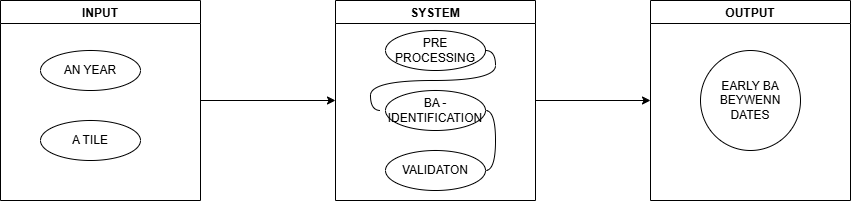

<hr style="border:2px inset #ff9900 ;">

<div style="text-align: center;">
<h1 style="text-align: center;color: #ff3300">
SUMMARY
</h1>
</div>


**PRE-PROCESSING**

- Needed imports  

- Search Filter
 
- Requests files 

- duplicate analysis

- List of files atribute table 

- Require CRS, Transforms, Bonds and Image

- Generete bbox for firespots

**BURNED AREAS IDENTIFICATION**

- use SCL diference 

- Generate dNBR SWIR mask 

**Validation**

- import Firespots in the bbox 

- Firespot intersect with ba_mask

- JSON response




<div style="text-align: center;">
<h1 style="text-align: center;color: #ff3300">
PRE-PROCESSING
</h1>
</div>

<hr style="border:2px inset #ff9900 ;">

<div>
<h1 style="color: #ff3300">
NEEDED IMPORTS
</h1>
</div>

<hr style="border:2px inset #ff9900 ;">

<div style="font-size: 90%;color: #cccc00">
All the needed imports will be parsed bellow for future access
</div>

## IMAGE ANALYSIS IMPORTS

The following imports are related to image analysis as well as API interactions with [bdc-stac](https://github.com/brazil-data-cube/bdc-stac).

### Package Requirements

This is the requirements file for the project, specifying the versions of the necessary packages.

### Dependency Packages

| Package        | Version    |
|----------------|------------|
| `geopandas`    | 1.0.1      |
| `requests`     | 2.32.3     |
| `pandas`       | 2.2.3      |
| `numpy`        | 2.1.3      |
| `shapely`      | 2.0.6      |
| `lxml`         | 5.3.0      |
| `tqdm`         | 4.67.1     |

### Other Dependencies

| Package            | Version    |
|--------------------|------------|
| `PyProj`           | 3.7.0      |
| `Rasterio`         | 1.4.3      |
| `Folium`           | 0.18.0     |
| `Matplotlib`       | 3.9.3      |
| `Pystac Client`    | 0.8.5      |


In [21]:
import requests
import geopandas as gpd
import shapely
import pyproj
import rasterio
import folium
import matplotlib
import pystac_client

print("Requests version:", requests.__version__)
print("GeoPandas version:", gpd.__version__)
print("Shapely version:", shapely.__version__)
print("PyProj version:", pyproj.__version__)
print("Rasterio version:", rasterio.__version__)
print("Folium version:", folium.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Pystac Client version:", pystac_client.__version__)

# === Standard Libraries ===
import xml.etree.ElementTree as ET  # Standard Library (no version needed)
from urllib.request import urlretrieve  # Standard Library (no version needed)
import requests  # Make sure to install using `pip install requests`
import bs4  # Install using `pip install beautifulsoup4`
import numpy as np  # Install using `pip install numpy`
import pandas as pd  # Install using `pip install pandas`

# === Geometry and Geoprocessing Libraries ===
import geopandas as gpd  # Install using `pip install geopandas`
from shapely.geometry import Point, MultiPoint, shape  # Install using `pip install shapely`
from pyproj import Proj, Transformer, CRS, transform  # Install using `pip install pyproj`

# === Raster Processing Libraries ===
import rasterio  # Install using `pip install rasterio`
from rasterio.features import shapes, rasterize  # These are part of rasterio
from rasterio.windows import bounds, from_bounds, Window  # These are part of rasterio

# === Visualization and Mapping Libraries ===
import folium  # Install using `pip install folium`

from matplotlib import pyplot as plt  # Install using `pip install matplotlib`


# === Time and Date Processing Libraries ===
from datetime import datetime, timedelta  # Standard Library (no version needed)

# === External Specific Libraries ===
import pystac_client  # Install using `pip install pystac-client`

# === Custom Internal Library ===
import early_ba_detection  # Custom library (ensure it's in your PYTHONPATH or installed)


Requests version: 2.32.3
GeoPandas version: 1.0.1
Shapely version: 2.0.6
PyProj version: 3.7.0
Rasterio version: 1.4.3
Folium version: 0.18.0
Matplotlib version: 3.9.3
Pystac Client version: 0.8.5


# Firespot Cluster Analysis Imports

The below imports are related to firespot cluster analysis. Defining firespots as [Active Fire Detection](https://forest-fire.emergency.copernicus.eu/about-effis/technical-background/active-fire-detection) centroids as well as the feature acquisition done with an [OGC-WFS Standard](https://www.ogc.org/publications/standard/wfs/) created by [*INPE Queimadas Program*](https://terrabrasilis.dpi.inpe.br/queimadas/portal/).

## Package Requirements

This is the requirements file for the project, specifying the versions of the necessary packages.

## Dependency Packages

| Package        | Version    |
|----------------|------------|
| `geopandas`    | 1.0.1      |
| `requests`     | 2.32.3     |
| `pandas`       | 2.2.3      |
| `numpy`        | 2.1.3      |
| `shapely`      | 2.0.6      |
| `lxml`         | 5.3.0      |
| `tqdm`         | 4.67.1     |


In [18]:
import geopandas as gpd
import requests
import pandas as pd
import numpy as np
import shapely
import lxml
import xml.etree.ElementTree as ET
import tqdm
versions = {
    "geopandas": gpd.__version__,
    "requests": requests.__version__,
    "pandas": pd.__version__,
    "numpy": np.__version__,
    "shapely": shapely.__version__,
    "lxml": lxml.__version__,
    "tqdm": tqdm.__version__,
}

import geopandas as gpd
import requests
import pandas as pd
import numpy as np
import shapely
import lxml
import xml.etree.ElementTree as ET
import tqdm
from shapely import Point


In [19]:
import xml as xml

In [20]:
xml.__spec__

ModuleSpec(name='xml', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7fe587e77850>, origin='/home/queimadas/miniconda3/envs/bdclab/lib/python3.10/xml/__init__.py', submodule_search_locations=['/home/queimadas/miniconda3/envs/bdclab/lib/python3.10/xml'])

<div>
<h1 style="color: #ff3300">
SEARCH_FILTER
</h1>
</div>


<hr style="border:2px inset #ff9900 ;">

<div style="font-size: 90%;color: #cccc00">
The parameters for filtering the data include the start and end dates, specifying the time range for the analysis. In this case, the start date is set to "2022-01-01" and the end date to "2022-12-30", covering the entire year of 2022. The tile parameter, '22LHH', refers to a specific geographic region or tile, which helps in narrowing down the area of interest for the analysis. Additionally, the cloud percentage filter is set to 50%, meaning only images with less than or equal to 50% cloud cover will be considered, ensuring clearer observations of the region.
</div>

In [ ]:
## FILTERS
start_date = "2022-01-01"
end_date = "2022-12-30"
tile='22LHH'
cloud_porcentage=50

<div>
<h1 style="color: #ff3300">
REQUESTS FILES
</h1>
</div>


<hr style="border:2px inset #ff9900 ;">

<div style="font-size: 90%;color: #cccc00">

This code snippet demonstrates how to query a STAC (SpatioTemporal Asset Catalog) service using the `pystac_client` library to retrieve satellite image data based on specific filters.

1. **Catalog URL**: The `catalog_url` is set to `'https://data.inpe.br/bdc/stac/v1/'`, which points to the STAC service hosted by INPE (National Institute for Space Research) in Brazil. This URL allows the client to connect to the data catalog and access available satellite imagery.

2. **Client Setup**: The line `pystac_client.Client.open(catalog_url)` opens the catalog and creates a client to interact with it, enabling the user to perform search queries on the STAC service.

3. **Search Parameters**:
   - **Collections**: The `collections` parameter specifies which satellite collection to search in. In this case, it is set to `'S2_L2A-1'`, which refers to a Sentinel-2 Level 2A dataset (surface reflectance data).
   - **Date Range**: The `datetime` parameter filters the data based on the specified start and end dates (`start_date` and `end_date`).
   - **Tile Filter**: The `query` parameter uses a filter to specify the geographic region. It checks for the presence of the desired tile (e.g., `'22LHH'`). The `bdc:tiles` filter helps target images from specific geographic tiles.
   - **Cloud Cover**: The `eo:cloud_cover` filter limits results to images with less than the specified cloud cover percentage (`cloud_porcentage`), ensuring that only clear images are returned.
   - **Sorting**: The `sortby` parameter sorts the results in ascending order based on the `datetime` field, meaning the oldest images will be returned first.
   - **Limit**: The `limit` parameter restricts the number of results to 100 to prevent overloading the system and to ensure the returned data can be processed in real-time.

This query enables researchers to retrieve satellite images that meet all the criteria, ensuring relevant data with the desired cloud cover, tile location, and date range.

</div>

In [ ]:
catalog_url = 'https://data.inpe.br/bdc/stac/v1/'
client = pystac_client.Client.open(catalog_url) # access the service
search = client.search(
    collections=['S2_L2A-1'],  # Colection name
    datetime=f"{start_date}/{end_date}",  # Filtro por data  
    query={"bdc:tiles":{'in':[f'{tile}']}, 'eo:cloud_cover':{"lt":cloud_porcentage}},
    sortby=[{
        'field': 'properties.datetime',
        'direction': 'asc'
    }],
    limit=100  # we do need to limitate to pass from an amount that is possible to be proccessed in real time
)

<div>
<h1 style="color: #ff3300">
REQUESTS FILES
</h1>
</div>

<hr style="border:2px inset #ff9900 ;">

<div style="font-size: 90%;color: #cccc00">
ALTER TEMPLATE INFO
</div>

In [ ]:
items = list(search.get_all_items())
i = 0
for item in items:
    
    if i >= 1:
        if items[i-1].datetime.date() == items[i].datetime.date():
            print(f'date equal {items[i-1].datetime} and {items[i].datetime}')
            print(f'file {items[i-1].id} and {items[i].id}')
            print(f"file {items[i-1].assets['PVI'].href}")
            print(f"file {items[i].assets['PVI'].href}")
        if items[i-2].datetime.date() == items[i-1].datetime.date():
            print(f'file {items[i-1].datetime} and {items[i-2].datetime}')
    i += 1


# exemple of two images at the same day

## image 1
<hr style="border:2px inset #ff9900">

![image.png](https://data.inpe.br/bdc/data/S2_L2A/v001/22/L/HH/2022/07/S2B_PVI_20220706T133149_N0400_R081_T22LHH_20220706T155133.png)

## image 2
<hr style="border:2px inset #ff9900">

![image-2.png](https://data.inpe.br/bdc/data/S2_L2A/v001/22/L/HH/2022/07/S2B_PVI_20220706T133149_N0400_R081_T22LHH_20220706T172430.png)

<h1 style="font-size: 150 ;color: #ff3300">
LIST OF FILES ATRIBUTE TABLE
</h1>

<hr style="border:2px inset #ff9900 ;">

<div style="font-size: 90%;color: #cccc00">
ALTER TEMPLATE INFO
</div>

In [ ]:
dates_after = []
dates_before = []
item_after = []
item_before = []
href_b8a_after = []
href_b8a_before = []
href_b11_after = []
href_b11_before = []
href_b12_after = []
href_b12_before = []
href_scl_after = []
href_scl_before = []
k=-1
for i in range(1, len(itens)):
    current_item = itens[i]
    prev_item = itens[i - 1]
    if current_item.datetime.date() != prev_item.datetime.date():
        # Comparação com o item anterior
        reference_item = prev_item
        # print(itens[i].datetime.date(),itens[i-1].datetime.date())
        if k==-1:
            if prev_item.datetime.date() != itens[i-2].datetime.date():
                k=-1
            else:
                i-=1
                k+=1
        else:
            prev_item=itens[i-2]
            k=-1
    if current_item.datetime.date() == prev_item.datetime.date():
        # Comparação com o item dois passos atrás
        reference_item = itens[i - 2]
        if k==-1:
            if reference_item.datetime.date() != itens[i-3].datetime.date():
                k=-1
            else:
                i-=1
                k+=1
        else:
            prev_item=itens[i-3].datetime.date()
            k=-1
        # print(itens[i].datetime.date(),itens[i-2].datetime.date())

    # Adicionando dados das datas
    dates_after.append(current_item.datetime.date())
    dates_before.append(reference_item.datetime.date())

    # Adicionando IDs
    item_after.append(current_item.id)
    item_before.append(reference_item.id)

    # Adicionando links
    href_b8a_after.append(current_item.assets['B8A'].href)
    href_b8a_before.append(reference_item.assets['B8A'].href)

    href_b11_after.append(current_item.assets['B11'].href)
    href_b11_before.append(reference_item.assets['B11'].href)

    href_b12_after.append(current_item.assets['B12'].href)
    href_b12_before.append(reference_item.assets['B12'].href)

    href_scl_after.append(current_item.assets['SCL'].href)
    href_scl_before.append(reference_item.assets['SCL'].href)

data_dict = {
    'dates_before': dates_before,
    'dates_after': dates_after,
    'item_before': item_before,
    'item_after': item_after,
    'href_b8a_before': href_b8a_before,
    'href_b8a_after': href_b8a_after,
    'href_b11_before': href_b11_before,
    'href_b11_after': href_b11_after,
    'href_b12_before': href_b12_before,
    'href_b12_after': href_b12_after,
    'href_scl_before': href_scl_before,
    'href_scl_after': href_scl_after
}

df = pd.DataFrame(data_dict)

df


<h1 style="font-size: 150 ;color: #ff3300">
Require CRS, Transforms, Bonds and Image
</h1>

<hr style="border:2px inset #ff9900 ;">

<div style="font-size: 90%;color: #cccc00">
ALTER TEMPLATE INFO
</div>

In [ ]:
df.iloc[76,]

asset_exemple = 76
scl_before=df.iloc[asset_exemple,10]
scl_after=df.iloc[asset_exemple,11]
href_b12_before=df.iloc[asset_exemple,8]
href_b12_after=df.iloc[asset_exemple,9]
href_b11_before=df.iloc[asset_exemple,6]
href_b11_after=df.iloc[asset_exemple,7]
href_b8a_before=df.iloc[asset_exemple,4]
href_b8a_after=df.iloc[asset_exemple,5]

## Read Tiff as a function 

Get the informations as transformes, bounds and crs aboutn

In [ ]:
def read_tiff_image(file_path):
    with rasterio.open(file_path) as src:
        image_data = src.read(1) 
        transform = src.transform  
        crs = src.crs  
        bounds = src.bounds 
    return image_data, transform, crs, bounds



# Exemple analysis 

In [ ]:
tiff_scl_before = read_tiff_image(scl_before)
bounds = tiff_scl_before[3]
crs = tiff_scl_before[2]
crs = CRS.from_wkt(f'{crs}')
epsg_code = crs.to_epsg()
epsg_code

In [ ]:
bounds

<div>
<h1 style="color: #ff3300">
GENERATE BBOX FOR FIRESPOTS
</h1>
</div>

<hr style="border:2px inset #ff9900 ;">

<div style="font-size: 90%;color: #cccc00">
Transformando os limites para EPSG:4326 (WGS84)
</br>
Imprimindo a BBOX no formato WGS84
</div>

In [ ]:

crs_original = CRS.from_epsg(epsg_code)  
crs_destino = CRS.from_epsg(4326)

# Transformando os limites para o EPSG:4326
bounds_4326 = rasterio.warp.transform_bounds(crs_original, crs_destino, 
                                bounds.left, bounds.bottom, 
                                bounds.right, bounds.top)

# Resultado no formato de BBOX
bbox_4326 = {
    "minx": bounds_4326[0],  # Longitude mínima
    "miny": bounds_4326[1],  # Latitude mínima
    "maxx": bounds_4326[2],  # Longitude máxima
    "maxy": bounds_4326[3],  # Latitude máxima
}

## The tile

The tile represented in wgs-84 is  presented bellow

In [ ]:
print(f"BBOX EPSG:4326: {bbox_4326}")

<div>
<h1 style="text-align: center;color: #ff3300">
BURNED AREAS IDENTIFICATION
</h1>
</div>
<hr style="border:2px inset #ff9900 ;">

<div>
<h1 style="color: #ff3300">
USE SCL DIFERENCE
</h1>
</div>

<hr style="border:2px inset #ff9900 ;">

<div style="font-size: 90%;color: #cccc00">
Create the function to generate the diference berwen two scl images
</div>

In [ ]:
def calculate_dscl(scl_path_before,scl_path_after):
    scl_data_before, transform, crs, scl_bounds_before = read_tiff_image(scl_path_before)
    scl_data_after, _, _, scl_bounds_after = read_tiff_image(scl_path_after)

    scl_mask_before = np.isin(scl_data_before, [4, 5])  
    scl_mask_after = np.isin(scl_data_after, [4, 5])

    scl_before = np.where (scl_mask_before, 1, np.nan)
    scl_after = np.where (scl_mask_after, 1, np.nan)
    dscl = scl_before*scl_after

    return dscl, transform, crs, scl_before,scl_after

In [ ]:
dscl, transform, crs, scl_before,scl_after = calculate_dscl(scl_before,scl_after)

In [ ]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(12, 4))
ax1.imshow(scl_before, cmap='grey')

ax2.imshow(scl_after, cmap='grey')

ax3.imshow(dscl, cmap='grey')


<div>
<h1 style="color: #ff3300">
GENERATE DNBR SWIR MASK
</h1>
</div>

<hr style="border:2px inset #ff9900 ;">

<div style="font-size: 90%;color: #cccc00">
ALTER TEMPLATE INFO
</div>

In [13]:
def calculate_dscl(scl_path_before,scl_path_after):
    scl_data_before, transform, crs, scl_bounds_before,bbox_4326 = read_tiff_image(scl_path_before)
    scl_data_after, _, _, scl_bounds_after,bbox_4326 = read_tiff_image(scl_path_after)

    scl_mask_before = np.isin(scl_data_before, [4, 5])  
    scl_mask_after = np.isin(scl_data_after, [4, 5])

    scl_before = np.where (scl_mask_before, 1, np.nan)
    scl_after = np.where (scl_mask_after, 1, np.nan)
    dscl = scl_before*scl_after

    return dscl, transform, crs,bbox_4326

In [14]:
def generate_data_frame(year,tile='22LHH',cloud_porcentage=50):
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-30"
    catalog_url = 'https://data.inpe.br/bdc/stac/v1/'
    client = pystac_client.Client.open(catalog_url) # access the service
    search = client.search(
        collections=['S2_L2A-1'],  # Colection name
        datetime=f"{start_date}/{end_date}",  # Filtro por data  
        query={"bdc:tiles":{'in':[f'{tile}']}, 'eo:cloud_cover':{"lt":cloud_porcentage}},
        sortby=[{
            'field': 'properties.datetime',
            'direction': 'asc'
        }],
        limit=100  # we do need to limitate to pass from an amount that is possible to be proccessed in real time
    )
    itens = list(search.get_all_items())
    dates_after = []
    dates_before = []
    item_after = []
    item_before = []
    href_b8a_after = []
    href_b8a_before = []
    href_b11_after = []
    href_b11_before = []
    href_b12_after = []
    href_b12_before = []
    href_scl_after = []
    href_scl_before = []
    k=-1
    for i in range(1, len(itens)):
        current_item = itens[i]
        prev_item = itens[i - 1]
        if current_item.datetime.date() != prev_item.datetime.date():
            # Comparação com o item anterior
            reference_item = prev_item
            # print(itens[i].datetime.date(),itens[i-1].datetime.date())
            if k==-1:
                if prev_item.datetime.date() != itens[i-2].datetime.date():
                    k=-1
                else:
                    i-=1
                    k+=1
            else:
                prev_item=itens[i-2]
                k=-1
        if current_item.datetime.date() == prev_item.datetime.date():
            # Comparação com o item dois passos atrás
            reference_item = itens[i - 2]
            if k==-1:
                if reference_item.datetime.date() != itens[i-3].datetime.date():
                    k=-1
                else:
                    i-=1
                    k+=1
            else:
                prev_item=itens[i-3].datetime.date()
                k=-1
            # print(itens[i].datetime.date(),itens[i-2].datetime.date())

        # Adicionando dados das datas
        dates_after.append(current_item.datetime.date())
        dates_before.append(reference_item.datetime.date())

        # Adicionando IDs
        item_after.append(current_item.id)
        item_before.append(reference_item.id)

        # Adicionando links
        href_b8a_after.append(current_item.assets['B8A'].href)
        href_b8a_before.append(reference_item.assets['B8A'].href)

        href_b11_after.append(current_item.assets['B11'].href)
        href_b11_before.append(reference_item.assets['B11'].href)

        href_b12_after.append(current_item.assets['B12'].href)
        href_b12_before.append(reference_item.assets['B12'].href)

        href_scl_after.append(current_item.assets['SCL'].href)
        href_scl_before.append(reference_item.assets['SCL'].href)

    data_dict = {
        'dates_before': dates_before,
        'dates_after': dates_after,
        'item_before': item_before,
        'item_after': item_after,
        'href_b8a_before': href_b8a_before,
        'href_b8a_after': href_b8a_after,
        'href_b11_before': href_b11_before,
        'href_b11_after': href_b11_after,
        'href_b12_before': href_b12_before,
        'href_b12_after': href_b12_after,
        'href_scl_before': href_scl_before,
        'href_scl_after': href_scl_after
    }

    df = pd.DataFrame(data_dict)

    return df


In [15]:
def read_tiff_image(file_path):
    with rasterio.open(file_path) as src:
        image_data = src.read(1) 
        transform = src.transform  
        crs = src.crs  
        bounds = src.bounds 
        epsg_code = crs.to_epsg()
        crs_original = CRS.from_epsg(epsg_code)  
        crs_destino = CRS.from_epsg(4326)

        # Transformando os limites para o EPSG:4326
        bounds_4326 = rasterio.warp.transform_bounds(crs_original, crs_destino, 
                                        bounds.left, bounds.bottom, 
                                        bounds.right, bounds.top)
        
        # Resultado no formato de BBOX
        bbox_4326 = {
            "minx": bounds_4326[0],  # Longitude mínima
            "miny": bounds_4326[1],  # Latitude mínima
            "maxx": bounds_4326[2],  # Longitude máxima
            "maxy": bounds_4326[3],  # Latitude máxima
        }   
    return image_data, transform, crs, bounds,bbox_4326

In [16]:
def genereta_nbr_and_nbr_swir(ddscl_mask, NIR2_path,SWIR2_path,SWIR1_path):
    NIR2_data, transform, crs, NIR2_bounds,bbox_4326 = read_tiff_image(NIR2_path)
    SWIR2_data, _, _, SWIR2_bounds,bbox_4326 = read_tiff_image(SWIR2_path)
    SWIR1_data, _, _, SWIR1_bounds,bbox_4326 = read_tiff_image(SWIR1_path)
    ddscl_mask=np.isin(ddscl_mask, [1])
    NIR2_data = np.where (ddscl_mask, np.array(NIR2_data, dtype=np.float32), np.nan)
    SWIR1_data = np.where (ddscl_mask, np.array(SWIR1_data, dtype=np.float32), np.nan)
    SWIR2_data = np.where (ddscl_mask, np.array(SWIR2_data, dtype=np.float32), np.nan)

    nbr = np.where(ddscl_mask, (NIR2_data - SWIR2_data) / (NIR2_data + SWIR2_data + 1e-20), np.nan) # this is as well a normalization
    nbr_swir = np.where(ddscl_mask, (SWIR1_data - SWIR2_data - 0.02) / (SWIR1_data + SWIR2_data + 1e-20 + 0.1), np.nan)
    return nbr, nbr_swir,bbox_4326

In [17]:
def dnbr_and_dnbr_swir(dscl,ref_b8a_before,href_b11_before,href_b12_before,ref_b8a_after,href_b11_after,href_b12_after):

    nbr_before, nbr_swir_before,bbox_4326 = genereta_nbr_and_nbr_swir(dscl,ref_b8a_before,href_b11_before,href_b12_before)
    nbr_after, nbr_swir_after,bbox_4326 = genereta_nbr_and_nbr_swir(dscl,ref_b8a_after,href_b11_after,href_b12_after)

    dnbr_swir = (nbr_swir_before -nbr_swir_after)/np.abs(nbr_swir_before+ 1e-20)
    dnbr = (nbr_before -nbr_after)/np.abs(nbr_before+1e-20)
    
    dnbr_swir_mask = np.zeros_like(dnbr_swir)
    dnbr_swir_mask[dnbr_swir < 1] =1 
    dnbr_swir_mask[dnbr_swir > 0.3] = 1  # Alta severidade
    dnbr_swir_mask[dnbr_swir <= 0.3] = np.nan  # Sem mudança
    dnbr_mask = np.zeros_like(dnbr) 
    dnbr_mask[dnbr > 0.2] = 1  # Alta severidade
    dnbr_mask[dnbr <= 0.2] = np.nan  # Sem mudança

    return dnbr_mask, dnbr_swir_mask,bbox_4326

In [18]:
df = generate_data_frame(year= '2022',tile='22LHH',cloud_porcentage=50)
asset_exemple = 76
scl_before=df.iloc[asset_exemple,10]
scl_after=df.iloc[asset_exemple,11]
href_b12_before=df.iloc[asset_exemple,8]
href_b12_after=df.iloc[asset_exemple,9]
href_b11_before=df.iloc[asset_exemple,6]
href_b11_after=df.iloc[asset_exemple,7]
href_b8a_before=df.iloc[asset_exemple,4]
href_b8a_after=df.iloc[asset_exemple,5]
item_before=df.iloc[asset_exemple,2]
item_after=df.iloc[asset_exemple,3]
dates_before=df.iloc[asset_exemple,0]
dates_after=df.iloc[asset_exemple,1]

dscl, transform, crs_original,bbox_4326 = calculate_dscl(scl_before,scl_after)
dnbr_mask, dnbr_swir_mask,bbox_4326 = dnbr_and_dnbr_swir(dscl,href_b8a_before,href_b11_before,href_b12_before,href_b8a_after,href_b11_after,href_b12_after)


/home/queimadas/miniconda3/envs/bdclab/lib/python3.10/site-packages/pystac_client/item_search.py:903: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


In [ ]:
plt.imshow(dscl)

In [ ]:
print("scl_before:", scl_before)
print("scl_after:", scl_after)
print("href_b12_before:", href_b12_before)
print("href_b12_after:", href_b12_after)
print("href_b11_before:", href_b11_before)
print("href_b11_after:", href_b11_after)
print("href_b8a_before:", href_b8a_before)
print("href_b8a_after:", href_b8a_after)

In [ ]:
# Calcular histogramas
hist_dnbr, bins_dnbr = np.histogram(dnbr_mask, bins=50, range=(0, 1))  # 50 bins no intervalo [0, 1]
hist_dnbr_swir, bins_dnbr_swir = np.histogram(dnbr_swir_mask, bins=50, range=(0, 1))

# Plotar imagens e histogramas
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Imagem 1
axes[0, 0].imshow(dnbr_mask, cmap='hot')
axes[0, 0].set_title("DNBR Mask")

# Histograma 1
axes[1, 0].bar(bins_dnbr[:-1], hist_dnbr, width=np.diff(bins_dnbr), edgecolor="black", align="edge")
axes[1, 0].set_title("Histogram of DNBR Mask")
axes[1, 0].set_xlabel("Pixel Value")
axes[1, 0].set_ylabel("Frequency")

# Imagem 2
axes[0, 1].imshow(dnbr_swir_mask, cmap='hot')
axes[0, 1].set_title("DNBR SWIR Mask")

# Histograma 2
axes[1, 1].bar(bins_dnbr_swir[:-1], hist_dnbr_swir, width=np.diff(bins_dnbr_swir), edgecolor="black", align="edge")
axes[1, 1].set_title("Histogram of DNBR SWIR Mask")
axes[1, 1].set_xlabel("Pixel Value")
axes[1, 1].set_ylabel("Frequency")

# Ajustar layout
plt.tight_layout()
plt.show()


<div>
<h1 style="text-align: center;color: #ff3300">
VALIDATION
</h1>
</div>

<div>
<h1 style="color: #ff3300">
IMPORT FIRE-SPOTS IN THE BBOX 
</h1>
</div>

<hr style="border:2px inset #ff9900 ;">

<div style="font-size: 90%;color: #cccc00">
ALTER TEMPLELE INFO
</div>

In [ ]:
def cluster_fire_spots(bbox_4326, year='2024', first_month='09', first_day='10', second_month='09', second_day='15'):
    """
    # Cluster Fire Spots Function

    This function, `cluster_fire_spots`, retrieves and analyzes fire spot data from the TerraBrasilis database (INPE - Brazilian National Institute for Space Research).

    ## Overview:
    The function retrieves fire spot data within a specified bounding box and date range. It queries the TerraBrasilis WFS (Web Feature Service) API for data on fire occurrences (called "focos") based on latitude, longitude, and timestamp.

    ## Parameters:
    - `bbox` (tuple): 
        - A tuple containing the bounding box coordinates in the form (lat_min, lon_min, lat_max, lon_max).
    - `year` (str): The year to filter the fire spots (default: `'2024'`).
    - `first_month` (str): The first month of the date range to filter fire spots (default: `'09'`).
    - `first_day` (str): The first day of the date range to filter fire spots (default: `'10'`).
    - `second_month` (str): The second month of the date range to filter fire spots (default: `'09'`).
    - `second_day` (str): The second day of the date range to filter fire spots (default: `'15'`).

    ## Returns:
    - A GeoDataFrame containing the fire spot data, including coordinates (latitude and longitude) and the corresponding timestamp of each fire occurrence.
    - The function also saves the resulting data as a GeoPackage file (`focosat_bbox.gpkg`).

    ## Usage Example:
    ```python
    bbox = (-10.0, -60.0, -5.0, -55.0)
    gdf = cluster_fire_spots(bbox, year='2023', first_month='01', first_day='01', second_month='01', second_day='15')
    print(gdf.head())
    """
    # Extracting boundaries from the bounding box
    try:
        lon_min = bbox_4326['minx']
        lat_min = bbox_4326['miny']
        lon_max = bbox_4326['maxx']
        lat_max = bbox_4326['maxy']
        print("Processing bounding box for boundaries...")
        print(f"Latitude mínima: {lat_min}")
        print(f"Longitude mínima: {lon_min}")
        print(f"Latitude máxima: {lat_max}")
        print(f"Longitude máxima: {lon_max}")

        # Retrieve fire spot data based on the provided bbox
        gdf = print_points(lat_min, lon_min, lat_max, lon_max, year, first_month, first_day, second_month, second_day)
        return gdf

    except Exception as e:
        print(f"Error: {e}")
        return False


def print_points(lat_min, lon_min, lat_max, lon_max, year, first_month, first_day, second_month, second_day):
    # Generating request URL
    path = f"https://terrabrasilis.dpi.inpe.br/queimadas/geoserver/wfs?SERVICE=WFS&REQUEST=GetFeature&VERSION=2.0.0&TYPENAMES=bdqueimadas3:focos&TYPENAME=bdqueimadas3:focos&SRSNAME=urn:ogc:def:crs:EPSG::4326&CQL_FILTER=data_hora_gmt%20between%20{year}-{first_month}-{first_day}T00%3A00%3A00%20and%20{year}-{second_month}-{second_day}T23%3A59%3A59%20AND%20longitude%20%3E%20{lon_min}%20AND%20longitude%20%3C%20{lon_max}%20AND%20latitude%20%3E%20{lat_min}%20AND%20latitude%20%3C%20{lat_max}"
    print("Fetching data from TerraBrasilis...")
    
    with tqdm(total=100, desc="Downloading Data") as pbar:
        response = requests.get(path)
        pbar.update(100)
    
    lat, lon, date = [], [], []
    xml_data = response.content
    root = ET.fromstring(xml_data)
    namespaces = {
        'wfs': 'http://www.opengis.net/wfs/2.0',
        'gml': 'http://www.opengis.net/gml/3.2',
        'bdqueimadas3': 'https://www.inpe.br/queimadas/bdqueimadas3'
    }

    print("Processing fire spot data...")
    for foco in tqdm(root.findall('.//wfs:member/bdqueimadas3:focos', namespaces), desc="Processing Fire Spots"):
        latitude = foco.find('bdqueimadas3:latitude', namespaces).text
        longitude = foco.find('bdqueimadas3:longitude', namespaces).text
        data_hora = foco.find('bdqueimadas3:data_hora_gmt', namespaces).text
        lat.append(latitude)
        lon.append(longitude)
        date.append(data_hora)

    focos_lat = np.array(lat)
    focos_lon = np.array(lon)
    focos_date = np.array(date)

    print("Creating GeoDataFrame...")
    
    result = list(zip(map(lambda x: float(x), focos_lon), map(lambda x: float(x), focos_lat)))
    d = {'coordinates': result, 'date': focos_date}
    df = pd.DataFrame(data=d)
    df['geometry'] = df['coordinates'].apply(lambda x: Point(x[0], x[1]))
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf.crs = {"init": "epsg:4326"}
    return gdf


In [ ]:
year = str(dates_before.year)
first_month = f"{dates_before.month:02d}"  
first_day = f"{dates_before.day:02d}"

year = str(dates_after.year) 
second_month = f"{dates_after.month:02d}" 
second_day = f"{dates_after.day:02d}" 
caminho_arquivo =  bbox_4326

In [ ]:
first_month,first_day,second_month,second_day

In [ ]:
focos = cluster_fire_spots(bbox_4326, year, first_month, first_day, second_month, second_day)

In [ ]:
focos

<h1 style="font-size: 150 ;color: #ff3300">
FIRE-SPOTS INTERSECTS WITH BA-MASK
</h1>

<hr style="border:2px inset #ff9900 ;">

<div style="font-size: 90%;color: #cccc00">
ALTER TEMPLATE INFO
</div>

In [ ]:
focos = focos.to_crs(epsg=f'{crs_original.to_epsg()}')
focos_buffer = focos.buffer(300)

gdf_focos_buffer = gpd.GeoDataFrame(geometry=focos_buffer, crs=focos.crs)

focos_buffer_mask = gdf_focos_buffer.dissolve()

In [ ]:
focos_buffer_mask

In [ ]:
shapes = ((geom, 1,) for geom in focos_buffer_mask.geometry)
focos_buffer_mask_rasterized = rasterize(shapes, out_shape=image.shape, transform=transform)

# Multiplicar a imagem pela máscara rasterizada
image_modified = image * rasterized

In [25]:
import numpy as np
from early_ba_detection_v01 import generate_data_frame,calculate_dscl,dnbr_and_dnbr_swir,cluster_fire_spots
import geopandas as gpd
from rasterio.features import rasterize
# Gera um DataFrame baseado nos parâmetros fornecidos
df = generate_data_frame(year='2022', tile='22LHH', cloud_porcentage=50)

i = 1
if i == 1:
    asset_exemple = 76

    scl_before = df.iloc[asset_exemple, 10]
    scl_after = df.iloc[asset_exemple, 11]
    href_b12_before = df.iloc[asset_exemple, 8]
    href_b12_after = df.iloc[asset_exemple, 9]
    href_b11_before = df.iloc[asset_exemple, 6]
    href_b11_after = df.iloc[asset_exemple, 7]
    href_b8a_before = df.iloc[asset_exemple, 4]
    href_b8a_after = df.iloc[asset_exemple, 5]
    item_before = df.iloc[asset_exemple, 2]
    item_after = df.iloc[asset_exemple, 3]
    dates_before = df.iloc[asset_exemple, 0]
    dates_after = df.iloc[asset_exemple, 1]

    # Calcula dscl e dnbr
    dscl, transform, crs_original, bbox_4326 = calculate_dscl(scl_before, scl_after)
    dnbr_mask, dnbr_swir_mask, bbox_4326 = dnbr_and_dnbr_swir(
        dscl, 
        href_b8a_before, href_b11_before, href_b12_before, 
        href_b8a_after, href_b11_after, href_b12_after
    )

    year = str(dates_before.year)
    first_month = f"{dates_before.month:02d}"  
    first_day = f"{dates_before.day:02d}"

    year = str(dates_after.year) 
    second_month = f"{dates_after.month:02d}" 
    second_day = f"{dates_after.day:02d}" 
    caminho_arquivo =  bbox_4326
    # Gera buffers e máscaras rasterizadas para focos de incêndio
    focos = cluster_fire_spots(bbox_4326, year, first_month, first_day, second_month, second_day)
    focos = focos.to_crs(epsg=f'{crs_original.to_epsg()}')
    focos_buffer = focos.buffer(300)

    gdf_focos_buffer = gpd.GeoDataFrame(geometry=focos_buffer, crs=focos.crs)
    focos_buffer_mask = gdf_focos_buffer.dissolve()
    shapes = ((geom, 1,) for geom in focos_buffer_mask.geometry)
    focos_buffer_mask_rasterized = rasterize(shapes, out_shape=dnbr_swir_mask.shape, transform=transform)

    # Calcula imagem modificada
    image_modified = dnbr_swir_mask * focos_buffer_mask_rasterized

    # Aplica a condição para gerar a máscara final
    image_conditioned = np.where(image_modified == 1, 1, np.nan)
    sum_values = np.nansum(image_conditioned)
    int(sum_values)


/home/queimadas/miniconda3/envs/bdclab/lib/python3.10/site-packages/pystac_client/item_search.py:903: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


Processing bounding box for boundaries...
Latitude mínima: -16.350529400566153
Longitude mínima: -48.205922378629374
Latitude máxima: -15.343921467332294
Longitude máxima: -47.165960838884224
Fetching data from TerraBrasilis...


Processing fire spot data...


Processing Fire Spots: 100%|██████████| 1399/1399 [00:00<00:00, 147841.55it/s]
/home/queimadas/miniconda3/envs/bdclab/lib/python3.10/site-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Creating GeoDataFrame...


In [26]:
sum_values = np.nansum(image_conditioned)
int(sum_values)

1274

<div>
<h1 style="color: #ff3300">
JSON RESPONSE
</h1>
</div>

<hr style="border:2px inset #ff9900 ;">

<div style="font-size: 90%;color: #cccc00">
ALTER TEMPLATE INFO
</div>

In [ ]:
import numpy as np
from early_ba_detection_v01 import generate_data_frame,calculate_dscl,dnbr_and_dnbr_swir,cluster_fire_spots
import geopandas as gpd
from rasterio.features import rasterize
# Gera um DataFrame baseado nos parâmetros fornecidos
df = generate_data_frame(year='2022', tile='22LHH', cloud_porcentage=50)
ba_files=[]
day_before_files=[]
day_after_files=[]
item_before_files=[]
item_after_files=[]
i = 1
# if i ==1 :
for i in range(len(df)-1):
    asset_exemple = i+1

    scl_before = df.iloc[asset_exemple, 10]
    scl_after = df.iloc[asset_exemple, 11]
    href_b12_before = df.iloc[asset_exemple, 8]
    href_b12_after = df.iloc[asset_exemple, 9]
    href_b11_before = df.iloc[asset_exemple, 6]
    href_b11_after = df.iloc[asset_exemple, 7]
    href_b8a_before = df.iloc[asset_exemple, 4]
    href_b8a_after = df.iloc[asset_exemple, 5]
    item_before = df.iloc[asset_exemple, 2]
    item_after = df.iloc[asset_exemple, 3]
    dates_before = df.iloc[asset_exemple, 0]
    dates_after = df.iloc[asset_exemple, 1]

    # Calcula dscl e dnbr
    dscl, transform, crs_original, bbox_4326 = calculate_dscl(scl_before, scl_after)
    dnbr_mask, dnbr_swir_mask, bbox_4326 = dnbr_and_dnbr_swir(
        dscl, 
        href_b8a_before, href_b11_before, href_b12_before, 
        href_b8a_after, href_b11_after, href_b12_after
    )

    year = str(dates_before.year)
    first_month = f"{dates_before.month:02d}"  
    first_day = f"{dates_before.day:02d}"

    year = str(dates_after.year) 
    second_month = f"{dates_after.month:02d}" 
    second_day = f"{dates_after.day:02d}" 
    caminho_arquivo =  bbox_4326
    # Gera buffers e máscaras rasterizadas para focos de incêndio
    focos = cluster_fire_spots(bbox_4326, year, first_month, first_day, second_month, second_day)
    focos = focos.to_crs(epsg=f'{crs_original.to_epsg()}')
    focos_buffer = focos.buffer(300)

    gdf_focos_buffer = gpd.GeoDataFrame(geometry=focos_buffer, crs=focos.crs)
    focos_buffer_mask = gdf_focos_buffer.dissolve()
    shapes = ((geom, 1,) for geom in focos_buffer_mask.geometry)
    focos_buffer_mask_rasterized = rasterize(shapes, out_shape=dnbr_swir_mask.shape, transform=transform)

    # Calcula imagem modificada
    image_modified = dnbr_mask*dnbr_swir_mask * focos_buffer_mask_rasterized

    # Aplica a condição para gerar a máscara final
    image_conditioned = np.where(image_modified == 1, 1, np.nan)
    sum_values = np.nansum(image_conditioned)
    pixels_sum=int(sum_values)

#################################################################################################
    file_in_the_df = asset_exemple

    if pixels_sum > 50:
        data_antes = df.iloc[file_in_the_df, 0].strftime('%Y-%m-%d') if isinstance(df.iloc[file_in_the_df, 0], pd.Timestamp) else str(df.iloc[file_in_the_df, 0])
        data_depois = df.iloc[file_in_the_df, 1].strftime('%Y-%m-%d') if isinstance(df.iloc[file_in_the_df, 1], pd.Timestamp) else str(df.iloc[file_in_the_df, 1])
        item_before = df.iloc[file_in_the_df, 2]
        item_after = df.iloc[file_in_the_df, 3]
        ba_detect = 1

        
        # resultado_df.to_json(f'resultado{asset_exemple}.json', orient='records', lines=False, force_ascii=False, indent=4)
        # print(f"Arquivo 'resultado{asset_exemple}.json' salvo com sucesso!")
    else:
        data_antes = df.iloc[file_in_the_df, 0].strftime('%Y-%m-%d') if isinstance(df.iloc[file_in_the_df, 0], pd.Timestamp) else str(df.iloc[file_in_the_df, 0])
        data_depois = df.iloc[file_in_the_df, 1].strftime('%Y-%m-%d') if isinstance(df.iloc[file_in_the_df, 1], pd.Timestamp) else str(df.iloc[file_in_the_df, 1])
        item_before = df.iloc[file_in_the_df, 2]
        item_after = df.iloc[file_in_the_df, 3]
        ba_detect = 0
    day_before_files.append(data_antes)
    day_after_files.append(data_depois)
    item_before_files.append(item_before)
    item_after_files.append(item_after)
    ba_files.append(ba_detect)
resultado_df = pd.DataFrame([{
        "day_before": day_before_files,
        "day_after": day_after_files,
        "item_before": item_before_files,
        "item_after": item_after_files,
        "ba_detect": ba_files
}])



In [54]:
resultado_df

,day_before,day_after,item_before,item_after,ba_detect
0,"[2022-01-17, 2022-01-19, 2022-01-22, 2022-01-2...","[2022-01-19, 2022-01-22, 2022-01-24, 2022-01-2...",[S2B_MSIL2A_20220117T133219_N0301_R081_T22LHH_...,[S2A_MSIL2A_20220119T132231_N0301_R038_T22LHH_...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ..."
